In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
import itertools
import argparse
import re
import os
import pickle
# packages that are used inside sklearn

from sklearn.preprocessing import StandardScaler

In [2]:

# Let's use AAPL (Apple), MSI (Motorola), SBUX (Starbucks)
def get_data():
  # returns a T x 3 list of stock prices
  # each row is a different stock
  # 0 = AAPL
  # 1 = MSI
  # 2 = SBUX
  df = pd.read_csv('aapl_msi_sbux.csv')
  return df.values.dropna()


In [3]:
data_name = 'combined_stable_data_test_2015'
def get_data():
  # returns a T x 3 list of stock prices
  # each row is a different stock
  # 0 = AAPL
  # 1 = MSI
  # 2 = SBUX
  df = pd.read_csv(data_name + ".csv")
  return df.values #.dropna()

In [4]:
def get_scaler(env):
  # return scikit-learn scaler object to scale the states
  states = []
  for _ in range(env.n_step):
    action = np.random.dirichlet(np.ones(env.n_stock)) # modified by FILIP
    state, reward, done, info = env.step(action)
    states.append(state)
    if done:
      break

  scaler = StandardScaler()
  scaler.fit(states)
  return scaler





In [5]:
def maybe_make_dir(directory):
  if not os.path.exists(directory):
    os.makedirs(directory)




In [6]:
class LinearModel:
  """ A linear regression model """
  def __init__(self, input_dim, n_stocks): # modified by FILIP
    self.n_stocks = int(n_stocks) # added by filip
    self.W = np.random.randn(input_dim, self.n_stocks) / np.sqrt(input_dim) # modified by FILIP
    self.b = np.zeros(self.n_stocks)

    # momentum terms
    self.vW = 0
    self.vb = 0

    self.losses = []

  def predict(self, X):
    # make sure X is N x D (N sample size - how many obs we use (below it is N = 1), D state dimension - 7 in our case)
    assert(len(X.shape) == 2) # assert is to chech if the condition is TRUE otherwise we have a warning error!
    output = (X.dot(self.W) + self.b)[0] # changed by FILIP

    min_value = np.min(output)
    if min_value < 0:
      shifted_output = output - min_value
    else:
      shifted_output = output
    normalized_output = shifted_output / np.sum(shifted_output)
    clipped_output = np.clip(normalized_output, 0.1, 0.9)
    difference = 1 - np.sum(clipped_output)
    while np.any(clipped_output < 0.1) or np.any(clipped_output > 0.9) or not np.isclose(np.sum(clipped_output), 1):
      for i in range(len(clipped_output)):
          if clipped_output[i] < 0.1:
              clipped_output[i] = 0.1
          elif clipped_output[i] > 0.9:
              clipped_output[i] = 0.9
      difference = 1 - np.sum(clipped_output)
      clipped_output += difference / len(clipped_output)
    final_output = clipped_output / np.sum(clipped_output)

    return final_output # changed by FILIP # this is N(=1) x n_stock vector
  
  def get_norm(self, X):
    output = (X.dot(self.W) + self.b)[0]
    
    return np.linalg.norm(output)

  def sgd(self, X, Y, learning_rate=0.01, momentum=0.9):
    # make sure X is a matrix 1 x D (Q-values)
    assert(len(X.shape) == 2)

    # X is the current Q(s,:)
    # Y is the target r + gamma max Q(s',:)
    # the loss values are 2-D
    # normally we would divide by N only
    # but now we divide by N x K - K is num_action, i.e. the number of outputs
    
    num_values = len(Y) # modified by FILIP

    # do one step of gradient descent
    # we multiply by 2 to get the exact gradient
    # (not adjusting the learning rate)
    # i.e. d/dx (x^2) --> 2x
    Yhat = self.predict(X)
    gW = 2 * X.T.dot((Yhat - Y).reshape(1, 3)) / num_values #/ self.get_norm(X) # modified by FILIP # here 2 is because of the derivative of the mean squared error \sum_{k=1}^n_action (y-yhat)^2
    gb = 2 * (Yhat - Y).sum(axis=0) / num_values #/ self.get_norm(X) # modified by FILIP

    # update momentum terms
    self.vW = momentum * self.vW - learning_rate * gW
    self.vb = momentum * self.vb - learning_rate * gb

    # update params
    self.W += self.vW
    self.b += self.vb

    mse = np.mean((Yhat - Y)**2)
    self.losses.append(mse)

  def load_weights(self, filepath):
    npz = np.load(filepath)
    self.W = npz['W']
    self.b = npz['b']

  def save_weights(self, filepath):
    np.savez(filepath, W=self.W, b=self.b)






In [7]:
class MultiStockEnv:
  """
  A 3-stock trading environment.
  State: vector of size 7 (n_stock * 2 + 1)
    - # shares of stock 1 owned
    - # shares of stock 2 owned
    - # shares of stock 3 owned
    - price of stock 1 (using daily close price)
    - price of stock 2
    - price of stock 3
    - cash owned (can be used to purchase more stocks)
  Action: categorical variable with 27 (3^3) possibilities
    - for each stock, you can:
    - 0 = sell
    - 1 = hold
    - 2 = buy
  """
  def __init__(self, data, initial_investment=20000):
    # data
    self.stock_price_history = data
    self.n_step, self.n_stock = self.stock_price_history.shape # table of n_days x 3 stocks

    # instance attributes
    self.initial_investment = initial_investment
    self.cur_step = None
    self.stock_owned = None
    self.stock_price = None
    self.cash_in_hand = None


    ######################### FILIP #################

    #self.action_space = np.arange(3**self.n_stock) # vector counting the number of possible actions: [0,1,2,...,26]

    ######################### FILIP #################


    # action permutations
    # returns a nested list with elements like:
    # [[0,0,0]
    # [0,0,1]
    # [0,0,2]
    # [0,1,0]
    # [0,1,1]...
    # [2,2,2]]
    # etc.
    # 0 = sell
    # 1 = hold
    # 2 = buy

    ######################### FILIP #################

    #self.action_list = list(map(list, itertools.product([0, 1, 2], repeat=self.n_stock)))

    ######################### FILIP #################
    # calculate size of state
    self.state_dim = self.n_stock * 2 + 1

    self.reset()


  def reset(self):
    self.cur_step = 0
    self.stock_owned = np.zeros(self.n_stock)
    self.stock_price = self.stock_price_history[self.cur_step]
    self.cash_in_hand = self.initial_investment
    return self._get_obs()

  ## FILIP - adjusting for continuous 
  def step(self, action):

    ######################## FILIP #######################
    #assert action in self.action_space
    assert len(action) == self.n_stock

    ################### FILIP ##############################

    # get current value before performing the action
    prev_val = self._get_val()

    # update price, i.e. go to the next day
    self.cur_step += 1
    self.stock_price = self.stock_price_history[self.cur_step]

    # perform the trade
    self._trade(action)
    #print(action) # for testing by FILIP

    # get the new portfolio value after taking the action
    cur_val = self._get_val()

    # reward is the increase in porfolio value
    reward = (cur_val - prev_val) / prev_val

    # done if we have run out of data
    done = self.cur_step == self.n_step - 1

    # store the current value of the portfolio here
    info = {'cur_val': cur_val}

    # output:
    return self._get_obs(), reward, done, info


  def _get_obs(self):
    obs = np.empty(self.state_dim)
    obs[:self.n_stock] = self.stock_owned
    obs[self.n_stock:2*self.n_stock] = self.stock_price
    obs[-1] = self.cash_in_hand
    return obs



  def _get_val(self):
    #print("stock", self.stock_owned) # testing purposes by FILIP
    #print("price", self.stock_price) # testing purposes by FILIP
    #print("cash", self.cash_in_hand) # testing purposes by FILIP
    return self.stock_owned.dot(self.stock_price) + self.cash_in_hand


## FILIP comment: when selling sell all, when buying, buy just one share
  def _trade(self, action):
    # index the action we want to perform
    # 0 = sell
    # 1 = hold
    # 2 = buy
    # e.g. [2,1,0] means:
    # buy first stock
    # hold second stock
    # sell third stock

        ######################### FILIP #################

    #action_vec = self.action_list[action]

        ######################### FILIP #################

    #action = np.array(action)
    portfolio_value = np.sum(self.stock_owned * self.stock_price) + self.cash_in_hand # calculating the portfolio value
    #print("action ", action) # for testing purposes FILIP
    #print("stock price ", self.stock_price)
    #print("portfolio value ", portfolio_value) # for testing purposes FILIP
    target_investment = action * portfolio_value
    #print("target investment ", target_investment) # for testing purposes FILIP
    self.stock_owned = target_investment / self.stock_price # instead on buying/selling, action focuses on ideal portfolio structure
    # this is equivalent to buying/selling, just different formulation
    #print("stock owned", self.stock_owned) # for testing purposes FILIP
    self.cash_in_hand = 0
    #print("------------------------------------") # for testing purposes FILIP

######################### FILIP #################

"""
    # determine which stocks to buy or sell
    sell_index = [] # stores index of stocks we want to sell
    buy_index = [] # stores index of stocks we want to buy
    for i, a in enumerate(action_vec):# i is the counting index: 0,1,2; a is the action; e.g. action_vec = [0,0,1] -> i= 0,1,2 (stock index), a = 0,0,1
      if a == 0:
        sell_index.append(i)
      elif a == 2:
        buy_index.append(i)

    # sell any stocks we want to sell
    # then buy any stocks we want to buy
    if sell_index:
      # NOTE: to simplify the problem, when we sell, we will sell ALL shares of that stock
      for i in sell_index:
        self.cash_in_hand += self.stock_price[i] * self.stock_owned[i]
        self.stock_owned[i] = 0
    if buy_index:
      # NOTE: when buying, we will loop through each stock we want to buy,
      #       and buy one share at a time until we run out of cash
      can_buy = True
      while can_buy:
        for i in buy_index:
          if self.cash_in_hand > self.stock_price[i]:
            self.stock_owned[i] += 1 # buy one share
            self.cash_in_hand -= self.stock_price[i]
          else:
            can_buy = False
"""

######################### FILIP #################





'\n    # determine which stocks to buy or sell\n    sell_index = [] # stores index of stocks we want to sell\n    buy_index = [] # stores index of stocks we want to buy\n    for i, a in enumerate(action_vec):# i is the counting index: 0,1,2; a is the action; e.g. action_vec = [0,0,1] -> i= 0,1,2 (stock index), a = 0,0,1\n      if a == 0:\n        sell_index.append(i)\n      elif a == 2:\n        buy_index.append(i)\n\n    # sell any stocks we want to sell\n    # then buy any stocks we want to buy\n    if sell_index:\n      # NOTE: to simplify the problem, when we sell, we will sell ALL shares of that stock\n      for i in sell_index:\n        self.cash_in_hand += self.stock_price[i] * self.stock_owned[i]\n        self.stock_owned[i] = 0\n    if buy_index:\n      # NOTE: when buying, we will loop through each stock we want to buy,\n      #       and buy one share at a time until we run out of cash\n      can_buy = True\n      while can_buy:\n        for i in buy_index:\n          if sel

In [8]:
class DQNAgent(object):
  def __init__(self, state_size): # modified by FILIP
    self.state_size = state_size # D
    #self.action_size = action_size # num_action or K = 27 before # commented by FILIP
    self.n_stocks = int((self.state_size - 1) / 2)
    self.gamma = 0.95  # discount rate
    self.epsilon = 1.0  # exploration rate
    self.epsilon_min = 0.01
    self.epsilon_decay = 0.995
    self.model = LinearModel(state_size, self.n_stocks)

  def act(self, state):#epsilon-greedy strategy
    if np.random.rand() <= self.epsilon:
      return np.random.dirichlet(np.ones(self.n_stocks)) # modified by FILIP
    act_values = self.model.predict(state)
    return act_values # modified by FILIP  # returns action: argmax of a 1 x D vector - [0] because here we have just N = 1 observation: 1 x D output of predict

  ####################### FILIP ######################################

  def get_target(self, state, next_state):
    
    state = state[0]
    next_state = next_state[0]

    #print(state) # testing purposes by FILIP
    #print(next_state) # testing purposes by FILIP
    next_prices = next_state[self.n_stocks : len(state)-1]
    #print("next prices ", next_prices) # testing purposes by FILIP
    current_prices = state[self.n_stocks : len(state)-1]
    #print("current prices ", current_prices) # testing purposes by FILIP
    rtrn = (next_prices - current_prices) / current_prices
    #print("return ", rtrn) # testing purposes by FILIP
    index_of_max_abs = np.argmax(np.abs(rtrn))
    output_vector = np.full_like(rtrn, 0.2/(len(rtrn)-1))
    output_vector[index_of_max_abs] = 0.8 if rtrn[index_of_max_abs] > 0 else -0.8
    return output_vector

  ####################### FILIP ######################################

  def train(self, state, action, reward, next_state, done):
    """
    if done:
      target = reward # terminal state    # commented by FILIP
    else:
      target = reward + self.gamma * self.model.predict(next_state) # any other state, this is r + \gamma Q(s',a')
    """

    #target_full = self.model.predict(state) # commented by FILIP # this is Q(s,:)
    target_full = self.get_target(state, next_state)  # modified by FILIP

    # Run one training step
    self.model.sgd(state, target_full) # gradient descent method: we update only Q(s,a) -> for action a

    if self.epsilon > self.epsilon_min:
      self.epsilon *= self.epsilon_decay #update of the \epsilon for learning -> decreasing in time


  def load(self, name):
    self.model.load_weights(name) # we load W and b


  def save(self, name):
    self.model.save_weights(name) # we save the new W and b - it is useful if we want to test some particula W and b at specific time




In [9]:
def play_one_episode(agent, env, is_train):
  # note: after transforming states are already 1xD
  # env is used to call the class "MultiStockEnv"
  state = env.reset()
  state = scaler.transform([state])
  done = False

  portfolio_values = np.array([])

  while not done:
    action = agent.act(state)
    next_state, reward, done, info = env.step(action)
    portfolio_values = np.append(portfolio_values, info["cur_val"])
    next_state = scaler.transform([next_state])
    if is_train == 'train':
      agent.train(state, action, reward, next_state, done)
    state = next_state

  return info['cur_val'], portfolio_values





In [10]:
if __name__ == '__main__':

  # config
  models_folder = 'linear_rl_trader_models'
  rewards_folder = 'linear_rl_trader_rewards'
  num_episodes = 100
  #batch_size = 32 # unuseful here - batch size for sampling
  initial_investment = 20000

  ####################### FILIP #####################################

  # this is to give the "train" or "test" mode as input when you run in the terminal
  #parser = argparse.ArgumentParser()
  #parser.add_argument('-m', '--mode', type=str, required=True,
  #                    help='either "train" or "test"')
  #args = parser.parse_args()

  ######################### FILIP #############################

  maybe_make_dir(models_folder)
  maybe_make_dir(rewards_folder)

  data = get_data()
  n_timesteps, n_stocks = data.shape

  n_train = n_timesteps // 2

  train_data = data # [:n_train] # commented by FILIP
  test_data = data # [n_train:] # commented by FILIP

  env = MultiStockEnv(train_data, initial_investment)
  state_size = env.state_dim
  #action_size = len(env.action_space) # commented by FILIP
  agent = DQNAgent(state_size) # modified by FILIP
  scaler = get_scaler(env)

  # store the final value of the portfolio (end of episode)
  portfolio_value = []

  # added by FILIP
  a = "test"

  # added by FILIP
  portfolio_episode_values = pd.DataFrame()

  if a == 'test':
    # then load the previous scaler
    with open(f'{models_folder}/scaler.pkl', 'rb') as f:
      scaler = pickle.load(f)

    # here for test we download the scaler -> we use the mean and std estimated on training set!

    # remake the env with test data
    env = MultiStockEnv(test_data, initial_investment)

    # make sure epsilon is not 1!
    # no need to run multiple episodes if epsilon = 0, it's deterministic
    agent.epsilon = 0.01

    # load trained weights
    agent.load(f'{models_folder}/linear.npz')

  # play the game num_episodes times
  for e in range(num_episodes):
    print("NEW EPISODE")
    t0 = datetime.now() # the time to measure the duration of each episode
    val, portfolio_values = play_one_episode(agent, env, a)
    portfolio_episode_values[f"episode_{e+1}"] = portfolio_values
    dt = datetime.now() - t0
    print(f"episode: {e + 1}/{num_episodes}, episode end value: {val:.2f}, duration: {dt}") # we print times for each episode
    portfolio_value.append(val) # append episode end portfolio value

  # save the weights when we are done
  if a == 'train':
    # save the DQN
    agent.save(f'{models_folder}/linear.npz')

    # save the scaler
    with open(f'{models_folder}/scaler.pkl', 'wb') as f:
      pickle.dump(scaler, f)

    # plot losses
    plt.plot(agent.model.losses)
    plt.show()


  # save portfolio value for each episode
  np.save(f'{rewards_folder}/{a}.npy', portfolio_value)

NEW EPISODE
episode: 1/100, episode end value: 21593.70, duration: 0:00:00.136131
NEW EPISODE
episode: 2/100, episode end value: 21701.75, duration: 0:00:00.116970
NEW EPISODE
episode: 3/100, episode end value: 21701.73, duration: 0:00:00.120683
NEW EPISODE
episode: 4/100, episode end value: 21676.16, duration: 0:00:00.126931
NEW EPISODE
episode: 5/100, episode end value: 21648.24, duration: 0:00:00.119975
NEW EPISODE
episode: 6/100, episode end value: 22010.81, duration: 0:00:00.119018
NEW EPISODE
episode: 7/100, episode end value: 21700.68, duration: 0:00:00.126394
NEW EPISODE
episode: 8/100, episode end value: 21680.25, duration: 0:00:00.127090
NEW EPISODE
episode: 9/100, episode end value: 21764.24, duration: 0:00:00.118018
NEW EPISODE
episode: 10/100, episode end value: 21540.18, duration: 0:00:00.109970
NEW EPISODE
episode: 11/100, episode end value: 21709.21, duration: 0:00:00.112017
NEW EPISODE
episode: 12/100, episode end value: 21695.98, duration: 0:00:00.105903
NEW EPISODE
e

In [11]:
portfolio_episode_values

,episode_1,episode_2,episode_3,episode_4,episode_5,episode_6,episode_7,episode_8,episode_9,episode_10,...,episode_91,episode_92,episode_93,episode_94,episode_95,episode_96,episode_97,episode_98,episode_99,episode_100
0,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,...,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
1,19605.827114,19605.827114,19605.827114,19605.827114,19605.827114,19605.827114,19605.827114,19605.827114,19605.827114,19605.827114,...,19605.827114,19605.827114,19605.827114,19605.827114,19605.827114,19605.827114,19605.827114,19605.827114,19605.827114,19605.827114
2,19700.116897,19700.116897,19700.116897,19700.116897,19700.116897,19700.116897,19700.116897,19700.116897,19700.116897,19700.116897,...,19700.116897,19700.116897,19700.116897,19700.116897,19700.116897,19700.116897,19700.116897,19700.116897,19700.116897,19700.116897
3,20158.179679,20158.179679,20158.179679,20158.179679,20158.179679,20158.179679,20158.179679,20158.179679,20158.179679,20158.179679,...,20158.179679,20158.179679,20158.179679,20158.179679,20158.179679,20158.179679,20158.179679,20158.179679,20158.179679,20158.179679
4,19467.331267,19467.331267,19467.331267,19467.331267,19467.331267,19467.331267,19467.331267,19467.331267,19467.331267,19467.331267,...,19467.331267,19467.331267,19467.331267,19467.331267,19467.331267,19467.331267,19467.331267,19467.331267,19467.331267,19467.331267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,20937.988116,21042.415109,21042.401802,21017.687982,20990.702230,21341.108676,21041.385509,21021.690471,21102.817621,20886.261274,...,20679.374147,20918.448405,21111.191222,21051.473869,21176.277565,21352.990826,21478.891267,20940.602173,21163.162449,21276.588958
247,21415.802721,21522.664240,21522.650623,21497.360602,21469.745709,21828.323928,21521.610634,21501.400666,21584.475143,21362.870137,...,21151.161682,21395.807529,21593.044003,21531.934211,21659.648151,21840.483272,21969.321187,21418.477714,21646.227178,21762.299154
248,21462.266416,21569.417062,21569.403408,21544.044914,21516.355288,21875.906677,21568.360603,21548.094260,21631.395445,21409.190813,...,21196.911645,21442.217184,21639.987536,21578.712139,21706.772376,21888.099127,22017.288232,21464.948640,21693.314976,21809.702266
249,21751.963546,21860.695804,21860.681948,21834.949033,21806.850646,22171.716351,21859.623744,21839.058062,21923.589602,21698.104980,...,21482.697398,21731.618514,21932.308630,21870.128142,22000.080411,22184.089258,22315.191461,21754.685346,21986.424099,22104.532347


In [12]:
#portfolio_episode_values.to_csv(data_name + "_portfolio_values", index = False)

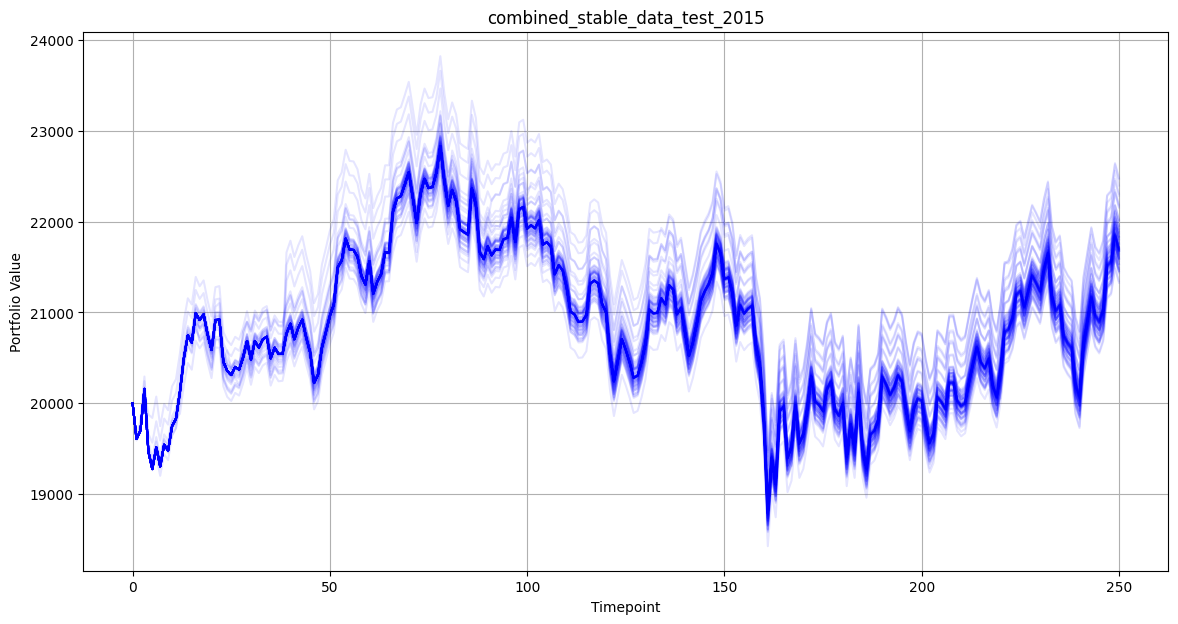

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample dataframe for demonstration
# portfolio_episode_values = pd.DataFrame({
#     'Value1': np.random.randn(100).cumsum(),
#     'Value2': np.random.randn(100).cumsum(),
#     'Value3': np.random.randn(100).cumsum()
# })

# Initialize the figure
plt.figure(figsize=(14, 7))

# Plot each column with reduced opacity
for column in portfolio_episode_values.columns:
    sns.lineplot(data=portfolio_episode_values[column], alpha=0.1, color = "blue")

plt.title(data_name)
plt.xlabel('Timepoint')
plt.ylabel('Portfolio Value')
plt.grid()
plt.show()
